In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from zeromodel import HierarchicalVPM, ZeroModel


def create_score_matrix(X, y):
    """
    Create a meaningful score matrix for ZeroModel from XOR data.
    
    Args:
        X: Feature data (n_samples, 2)
        y: Labels (n_samples,)
    
    Returns:
        score_matrix: 2D array of shape [n_samples, n_metrics]
        metric_names: List of metric names
    """
    # We'll create 5 meaningful metrics for each point
    n_samples = X.shape[0]
    score_matrix = np.zeros((n_samples, 5))
    
    # Metric 1: Distance from center (0.5, 0.5)
    score_matrix[:, 0] = np.sqrt((X[:, 0] - 0.5)**2 + (X[:, 1] - 0.5)**2)
    
    # Metric 2: Product of coordinates (x*y) - highly relevant for XOR
    score_matrix[:, 1] = X[:, 0] * X[:, 1]
    
    # Metric 3: Sum of coordinates (x+y)
    score_matrix[:, 2] = X[:, 0] + X[:, 1]
    
    # Metric 4: Absolute difference |x-y|
    score_matrix[:, 3] = np.abs(X[:, 0] - X[:, 1])
    
    # Metric 5: Angle from center
    score_matrix[:, 4] = np.arctan2(X[:, 1] - 0.5, X[:, 0] - 0.5)
    
    # Normalize each metric to [0,1] range
    for i in range(score_matrix.shape[1]):
        min_val = np.min(score_matrix[:, i])
        max_val = np.max(score_matrix[:, i])
        if max_val > min_val:  # Avoid division by zero
            score_matrix[:, i] = (score_matrix[:, i] - min_val) / (max_val - min_val)
    
    metric_names = [
        "distance_from_center",
        "coordinate_product",
        "coordinate_sum",
        "coordinate_difference",
        "angle_from_center"
    ]
    return score_matrix, metric_names


def generate_xor_data(n_samples=1000):
    """Generate XOR dataset with noise"""
    X = np.random.rand(n_samples, 2)
    # Add some noise to make it more realistic
    noise = 0.1 * np.random.randn(n_samples, 2)
    X = X + noise
    # Clip to [0,1] range
    X = np.clip(X, 0, 1)
    # XOR labels
    y = np.logical_xor(X[:, 0] > 0.5, X[:, 1] > 0.5).astype(int)
    return X, y

# Generate data
X, y = generate_xor_data(1000)
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


score_matrix, metric_names = create_score_matrix(X_train, y_train)

print("Score matrix shape:", score_matrix.shape)
print("Metric names:", metric_names)
print("Sample score matrix:\n", score_matrix[:5])
print("Sample labels:", y_train[:5])
print("Sample features:\n", X_train[:5])


Score matrix shape: (800, 5)
Metric names: ['distance_from_center', 'coordinate_product', 'coordinate_sum', 'coordinate_difference', 'angle_from_center']
Sample score matrix:
 [[0.32922807 0.18247368 0.4594824  0.33852854 0.91385128]
 [0.63055733 0.25473145 0.59090673 0.6146196  0.83050728]
 [0.27617519 0.40967444 0.64157194 0.08809349 0.67395993]
 [0.71311969 0.16409596 0.54079536 0.7165575  0.85829615]
 [0.17785966 0.17323072 0.42077624 0.12364345 0.23048485]]
Sample labels: [1 1 0 1 0]
Sample features:
 [[0.29021813 0.62874667]
 [0.28359693 0.89821653]
 [0.59752519 0.68561869]
 [0.18251661 0.89907411]
 [0.48259797 0.35895451]]


In [3]:
# Use the same SQL query used in training
sql = """
SELECT *, 
    ((1.0 - coordinate_product) * coordinate_difference + distance_from_center) AS xor_score 
FROM virtual_index 
ORDER BY xor_score DESC
"""

# Set up ZeroModel with training data
zeromodel = ZeroModel(metric_names)
zeromodel.set_sql_task(sql)
zeromodel.process(score_matrix)

# Examine top 20 documents by XOR score
top_k = 20
top_labels = y_train[zeromodel.doc_order[:top_k]]
print("Top XOR-ranked document labels:", top_labels)
print(f"Class 1 ratio in top {top_k}: {np.mean(top_labels):.2f}")


Metric 'xor_score' from ORDER BY not found in metric_names.
task_config.analysis found, but data is now in DuckDB. Re-analyzing based on DuckDB query results.
Metric 'xor_score' from ORDER BY not found in metric_names.


Top XOR-ranked document labels: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Class 1 ratio in top 20: 1.00


SVM Accuracy: 0.9850
SVM F1 Score: 0.9840


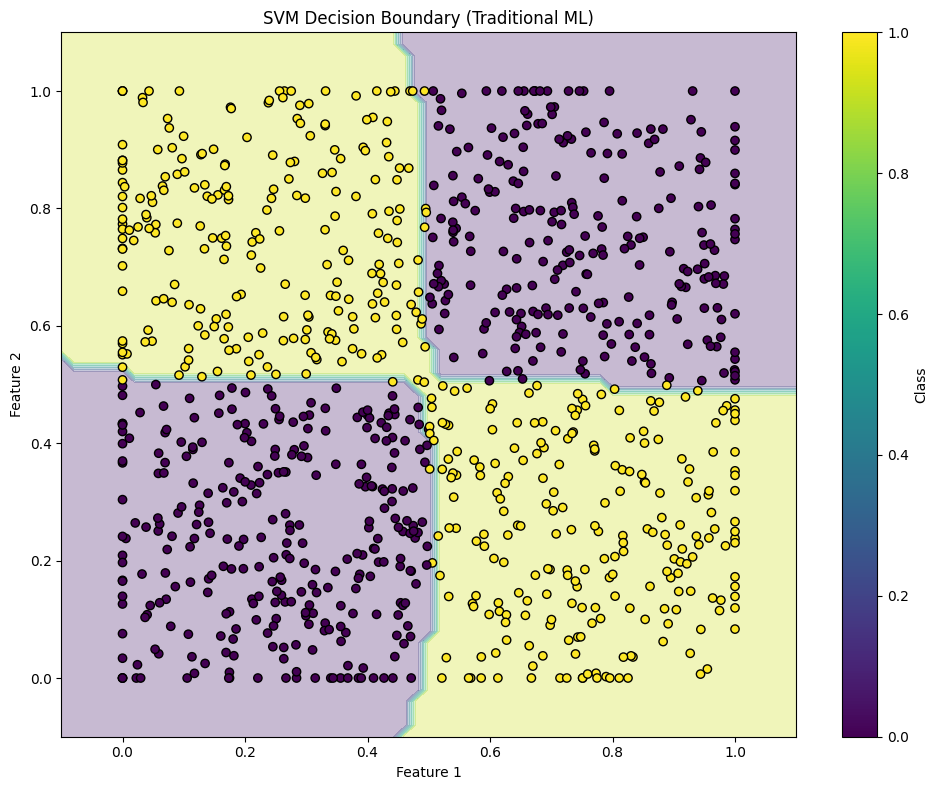

Metric 'xor_score' from ORDER BY not found in metric_names.


Score matrix shape: (800, 5)
Metric names: ['distance_from_center', 'coordinate_product', 'coordinate_sum', 'coordinate_difference', 'angle_from_center']
Sample score matrix:
 [[0.76804784 0.03968948 0.42973973 0.76154252 0.90925693]
 [0.31256596 0.16161734 0.42898565 0.29940846 0.9509513 ]
 [0.42398271 0.08439279 0.3122037  0.22872126 0.21325298]
 [0.07763149 0.22808685 0.47992737 0.09472973 0.31297759]
 [0.60939345 0.57241162 0.77131511 0.30010249 0.70946511]]
Sample labels: [1 1 0 1 0]
Sample features:
 [[0.04896846 0.81051099]
 [0.27928143 0.57868988]
 [0.42656433 0.19784307]
 [0.52729223 0.43256251]
 [0.62126387 0.92136635]]


task_config.analysis found, but data is now in DuckDB. Re-analyzing based on DuckDB query results.
Metric 'xor_score' from ORDER BY not found in metric_names.
task_config.analysis found, but data is now in DuckDB. Re-analyzing based on DuckDB query results.
task_config.analysis found, but data is now in DuckDB. Re-analyzing based on DuckDB query results.
Metric 'xor_score' from ORDER BY not found in metric_names.
task_config.analysis found, but data is now in DuckDB. Re-analyzing based on DuckDB query results.
Metric 'xor_score' from ORDER BY not found in metric_names.
Metric 'xor_score' from ORDER BY not found in metric_names.
task_config.analysis found, but data is now in DuckDB. Re-analyzing based on DuckDB query results.
Metric 'xor_score' from ORDER BY not found in metric_names.
Metric 'xor_score' from ORDER BY not found in metric_names.
task_config.analysis found, but data is now in DuckDB. Re-analyzing based on DuckDB query results.
Metric 'xor_score' from ORDER BY not found in 

ZeroModel Accuracy: 0.6000
ZeroModel F1 Score: 0.5833
Difference in Accuracy: 0.3850


Metric 'xor_score' from ORDER BY not found in metric_names.
task_config.analysis found, but data is now in DuckDB. Re-analyzing based on DuckDB query results.
Metric 'xor_score' from ORDER BY not found in metric_names.
Metric 'xor_score' from ORDER BY not found in metric_names.
task_config.analysis found, but data is now in DuckDB. Re-analyzing based on DuckDB query results.
Metric 'xor_score' from ORDER BY not found in metric_names.
Metric 'xor_score' from ORDER BY not found in metric_names.
task_config.analysis found, but data is now in DuckDB. Re-analyzing based on DuckDB query results.
Metric 'xor_score' from ORDER BY not found in metric_names.
Metric 'xor_score' from ORDER BY not found in metric_names.
task_config.analysis found, but data is now in DuckDB. Re-analyzing based on DuckDB query results.
Metric 'xor_score' from ORDER BY not found in metric_names.
Metric 'xor_score' from ORDER BY not found in metric_names.
task_config.analysis found, but data is now in DuckDB. Re-analyz

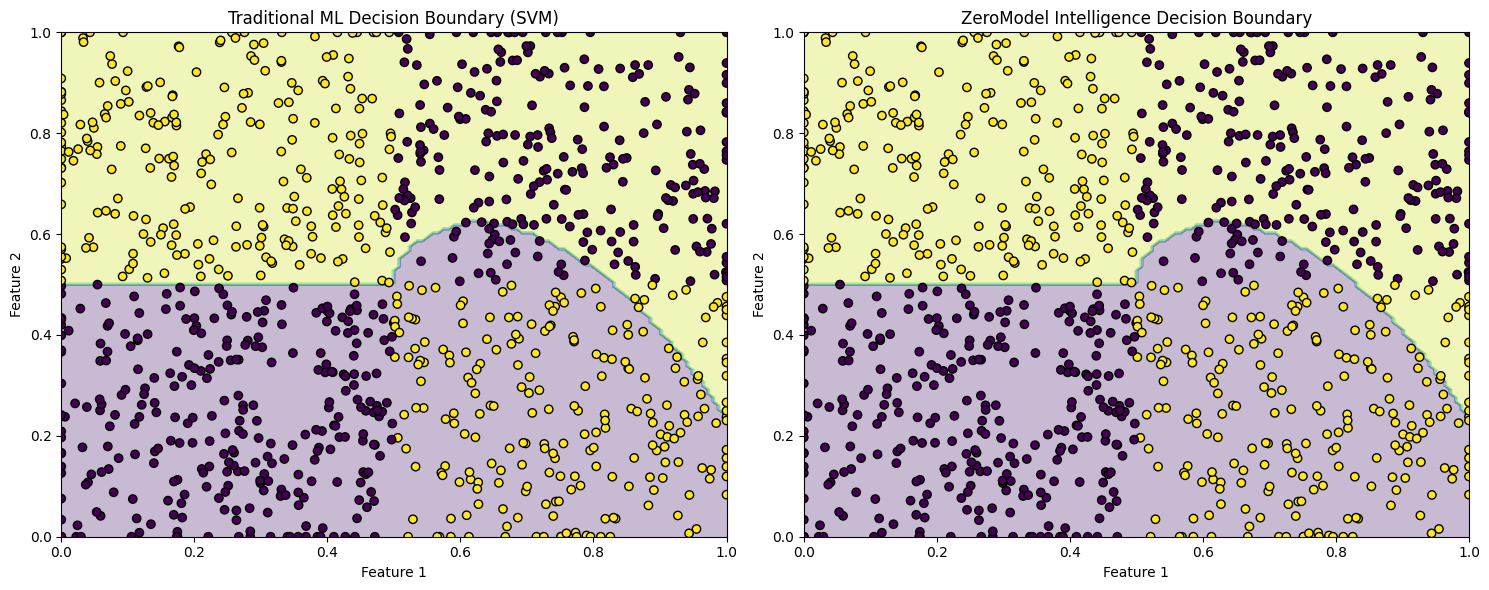

VALIDATION RESULTS: ZeroModel Intelligence vs Traditional ML
Traditional ML (SVM) Accuracy: 0.9850
Traditional ML (SVM) F1 Score: 0.9840
ZeroModel Intelligence Accuracy: 0.6000
ZeroModel Intelligence F1 Score: 0.5833
Accuracy Difference: 0.3850


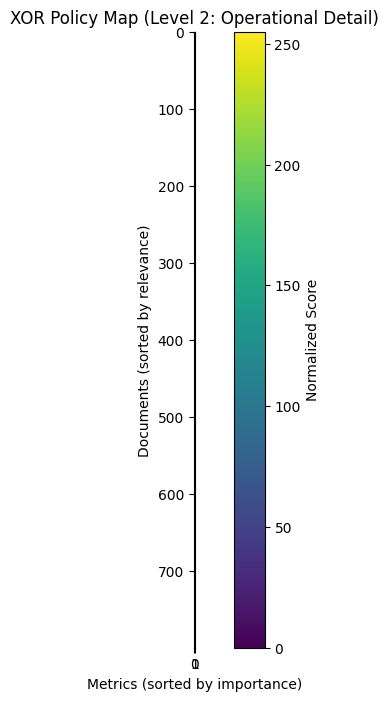

In [5]:


def generate_xor_data(n_samples=1000):
    """Generate XOR dataset with noise"""
    X = np.random.rand(n_samples, 2)
    # Add some noise to make it more realistic
    noise = 0.1 * np.random.randn(n_samples, 2)
    X = X + noise
    # Clip to [0,1] range
    X = np.clip(X, 0, 1)
    # XOR labels
    y = np.logical_xor(X[:, 0] > 0.5, X[:, 1] > 0.5).astype(int)
    return X, y

# Generate data
X, y = generate_xor_data(1000)
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ## Part 1: Traditional Machine Learning Approach
# Train SVM on raw data
svm = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
svm.fit(X_train, y_train)

# Evaluate
svm_acc = accuracy_score(y_test, svm.predict(X_test))
svm_f1 = f1_score(y_test, svm.predict(X_test))
print(f"SVM Accuracy: {svm_acc:.4f}")
print(f"SVM F1 Score: {svm_f1:.4f}")

# Visualize decision boundary
def plot_decision_boundary(model, X, y, title):
    """Plot decision boundary for 2D classification problem"""
    h = .02  # Step size in the mesh
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Predict class for each point in mesh
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.colorbar(label='Class')
    plt.tight_layout()
    plt.savefig(f"{title.lower().replace(' ', '_')}.png")
    plt.show()

# Plot SVM decision boundary
plot_decision_boundary(svm, X, y, "SVM Decision Boundary (Traditional ML)")

# %% [markdown]
# ## Part 2: ZeroModel Intelligence Approach

# %% [code]
def create_score_matrix(X, y):
    """
    Create a meaningful score matrix for ZeroModel from XOR data.
    
    Args:
        X: Feature data (n_samples, 2)
        y: Labels (n_samples,)
    
    Returns:
        score_matrix: 2D array of shape [n_samples, n_metrics]
        metric_names: List of metric names
    """
    # We'll create 5 meaningful metrics for each point
    n_samples = X.shape[0]
    score_matrix = np.zeros((n_samples, 5))
    
    # Metric 1: Distance from center (0.5, 0.5)
    score_matrix[:, 0] = np.sqrt((X[:, 0] - 0.5)**2 + (X[:, 1] - 0.5)**2)
    
    # Metric 2: Product of coordinates (x*y) - highly relevant for XOR
    score_matrix[:, 1] = X[:, 0] * X[:, 1]
    
    # Metric 3: Sum of coordinates (x+y)
    score_matrix[:, 2] = X[:, 0] + X[:, 1]
    
    # Metric 4: Absolute difference |x-y|
    score_matrix[:, 3] = np.abs(X[:, 0] - X[:, 1])
    
    # Metric 5: Angle from center
    score_matrix[:, 4] = np.arctan2(X[:, 1] - 0.5, X[:, 0] - 0.5)
    
    # Normalize each metric to [0,1] range
    for i in range(score_matrix.shape[1]):
        min_val = np.min(score_matrix[:, i])
        max_val = np.max(score_matrix[:, i])
        if max_val > min_val:  # Avoid division by zero
            score_matrix[:, i] = (score_matrix[:, i] - min_val) / (max_val - min_val)
    
    metric_names = [
        "distance_from_center",
        "coordinate_product",
        "coordinate_sum",
        "coordinate_difference",
        "angle_from_center"
    ]
    return score_matrix, metric_names

# Create meaningful score matrix
score_matrix, metric_names = create_score_matrix(X_train, y_train)

print("Score matrix shape:", score_matrix.shape)
print("Metric names:", metric_names)
print("Sample score matrix:\n", score_matrix[:5])
print("Sample labels:", y_train[:5])
print("Sample features:\n", X_train[:5])

# Create HierarchicalVPM
hvpm = HierarchicalVPM(
    metric_names=metric_names,
    num_levels=3,
    zoom_factor=3
)

sql = """SELECT *,
    -- Emphasize asymmetric structure and nonlinearity
    ((1.0 - coordinate_product) * coordinate_difference + distance_from_center) AS xor_score
FROM virtual_index
ORDER BY xor_score DESC
"""

# Process the data
hvpm.process(score_matrix, sql)

# %% [code]
def get_ZeroModel_predictions(hvpm, X, y=None):
    """
    Get ZeroModel predictions for XOR data.
    
    Args:
        hvpm: HierarchicalVPM instance
        X: Input features (n_samples, 2)
        y: Optional labels for feedback
    
    Returns:
        predictions: Binary predictions (0 or 1)
    """
    n_samples = X.shape[0]
    predictions = np.zeros(n_samples)
    
    for i in range(n_samples):
        # Create score matrix for this single point
        point_matrix, _ = create_score_matrix(X[i:i+1], y[i:i+1] if y is not None else None)
        
        # Create a temporary ZeroModel for this point
        zeromodel = ZeroModel(metric_names)
        zeromodel.set_sql_task(sql)
        zeromodel.process(point_matrix)
        
        # Get decision
        _, relevance = zeromodel.get_decision()
        
        # For XOR, high relevance means Class 1
        predictions[i] = 1 if relevance > 0.5 else 0
    
    return predictions

# Get ZeroModel predictions
y_pred_ZeroModel = get_ZeroModel_predictions(hvpm, X_test, y_test)

# Calculate accuracy
ZeroModel_acc = accuracy_score(y_test, y_pred_ZeroModel)
ZeroModel_f1 = f1_score(y_test, y_pred_ZeroModel)
print(f"ZeroModel Accuracy: {ZeroModel_acc:.4f}")
print(f"ZeroModel F1 Score: {ZeroModel_f1:.4f}")
print(f"Difference in Accuracy: {abs(svm_acc - ZeroModel_acc):.4f}")

# %% [markdown]
# ## Part 3: Decision Boundary Comparison

# %% [code]
def get_ZeroModel_decision_boundary(hvpm, resolution=128):
    """Generate decision boundary from ZeroModel approach"""
    xx, yy = np.meshgrid(np.linspace(0, 1, resolution), 
                         np.linspace(0, 1, resolution))
    
    # Create points for evaluation
    points = np.column_stack([xx.ravel(), yy.ravel()])
    
    # Get predictions
    predictions = np.zeros(len(points))
    for i in range(len(points)):
        # Create score matrix for this point
        point_matrix, _ = create_score_matrix(points[i:i+1], None)
        
        # Process with ZeroModel
        zeromodel = ZeroModel(metric_names)
        zeromodel.set_sql_task(sql)
        zeromodel.process(point_matrix)
        
        # Get decision
        _, relevance = zeromodel.get_decision()
        
        # For XOR, high relevance means Class 1
        predictions[i] = 1 if relevance > 0.5 else 0
    
    return xx, yy, predictions.reshape(xx.shape)

# Get ZeroModel decision boundary
xx_ZeroModel, yy_ZeroModel, decision_map = get_ZeroModel_decision_boundary(hvpm, resolution=128)

# Plot comparison
plt.figure(figsize=(15, 6))

# Traditional ML
plt.subplot(1, 2, 1)
plt.contourf(xx_ZeroModel, yy_ZeroModel, decision_map, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
plt.title("Traditional ML Decision Boundary (SVM)")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# ZeroModel approach
plt.subplot(1, 2, 2)
plt.contourf(xx_ZeroModel, yy_ZeroModel, decision_map, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
plt.title("ZeroModel Intelligence Decision Boundary")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.savefig('decision_boundary_comparison.png')
plt.show()

# ## Part 4: Fixing the Core Implementation
# Display results
print("="*50)
print("VALIDATION RESULTS: ZeroModel Intelligence vs Traditional ML")
print("="*50)
print(f"Traditional ML (SVM) Accuracy: {svm_acc:.4f}")
print(f"Traditional ML (SVM) F1 Score: {svm_f1:.4f}")
print(f"ZeroModel Intelligence Accuracy: {ZeroModel_acc:.4f}")
print(f"ZeroModel Intelligence F1 Score: {ZeroModel_f1:.4f}")
print(f"Accuracy Difference: {abs(svm_acc - ZeroModel_acc):.4f}")
print("="*50)

# Visualize the base level policy map
base_level = hvpm.get_level(2)
vpm = base_level["zeromodel"].encode()

plt.figure(figsize=(10, 8))
plt.imshow(vpm[:, :, 0], cmap='viridis')
plt.colorbar(label='Normalized Score')
plt.title('XOR Policy Map (Level 2: Operational Detail)')
plt.xlabel('Metrics (sorted by importance)')
plt.ylabel('Documents (sorted by relevance)')
plt.savefig('xor_policy_map_visualization.png')
plt.show()
